[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/jbcol/ML/blob/main/src/project.ipynb)

DOS: denial-of-service, e.g. syn flood;

R2L: unauthorized access from a remote machine, e.g. guessing password;

U2R:  unauthorized access to local superuser (root) privileges, e.g., various ``buffer overflow'' attacks;

probing: surveillance and other probing, e.g., port scanning.

In [8]:
import pandas as pd # For dataframes (tables)
import numpy as np # For numerical operations
import math
import matplotlib.pyplot as plt # For plots
import os # To import external python files
import sys# To import external python files
import category_encoders as ce
from pandas.plotting import scatter_matrix
from sklearn.pipeline import make_pipeline
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.model_selection import train_test_split, RandomizedSearchCV, KFold
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
from collections import Counter
import pickle # To save the model
from os.path import isfile
from imblearn.over_sampling import SMOTE

# We import a function I prepared for you in the course library if it not already there
if not os.path.exists('visualization.py'):
    !wget https://raw.githubusercontent.com/andreaaraldo/machine-learning-for-networks/master/course_library/visualization.py

import visualization
from visualization import plot_conf_mat

# we download the dataset if it is not already there
try:
    if not os.path.exists('kddcup.data_10_percent.gz'):
        !wget http://kdd.ics.uci.edu/databases/kddcup99/kddcup.data_10_percent.gz
        #!gzip -dk -f kddcup.data_10_percent.gz
except:
    print("Error while downloading the dataset")
    !wget http://kdd.ics.uci.edu/databases/kddcup99/kddcup.data_10_percent.gz
    raise

import gzip
with gzip.open('kddcup.data_10_percent.gz', 'rb') as file_in:
    with open('kddcup.data_10_percent', 'wb') as file_out:
        file_out.write( file_in.read() )


labels = "duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed_logins,logged_in,num_compromised,root_shell,su_attempted,num_root,num_file_creations,num_shells,num_access_files,num_outbound_cmds,is_host_login,is_guest_login,count,srv_count,serror_rate,srv_serror_rate,rerror_rate,srv_rerror_rate,same_srv_rate,diff_srv_rate,srv_diff_host_rate,dst_host_count,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,attack\n"
with open('kddcup.data_10_percent', 'r+') as file:
    content = file.read()
    file.seek(0, 0)  # Move the file cursor to the beginning of the file
    file.write(labels + content)

df = pd.read_csv('kddcup.data_10_percent')


encoderProtocol = ce.OneHotEncoder(cols=['protocol_type'], use_cat_names=True)
df = encoderProtocol.fit_transform(df)

encoderService = ce.OneHotEncoder(cols=['service'], use_cat_names=True)
df = encoderService.fit_transform(df)

encoderFlag = ce.OneHotEncoder(cols=['flag'], use_cat_names=True)
df = encoderFlag.fit_transform(df)

--2023-10-12 22:16:10--  http://kdd.ics.uci.edu/databases/kddcup99/kddcup.data_10_percent.gz
Résolution de kdd.ics.uci.edu (kdd.ics.uci.edu)… 128.195.1.86
Connexion à kdd.ics.uci.edu (kdd.ics.uci.edu)|128.195.1.86|:80… connecté.
requête HTTP transmise, en attente de la réponse… 200 OK
Taille : 2144903 (2,0M) [application/x-gzip]
Sauvegarde en : « kddcup.data_10_percent.gz »

kddcup.data_10_perc 100%[===================>]   2,04M  1,56MB/s    ds 1,3s    

2023-10-12 22:16:12 (1,56 MB/s) — « kddcup.data_10_percent.gz » sauvegardé [2144903/2144903]



/run/media/col/Data/DATA/TSP/CSN/machineLearningForNetworks/mlnet/venv/lib64/python3.11/site-packages/category_encoders/utils.py:28: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  elif pd.api.types.is_categorical_dtype(cols):
/run/media/col/Data/DATA/TSP/CSN/machineLearningForNetworks/mlnet/venv/lib64/python3.11/site-packages/category_encoders/utils.py:50: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return pd.api.types.is_categorical_dtype(dtype)
/run/media/col/Data/DATA/TSP/CSN/machineLearningForNetworks/mlnet/venv/lib64/python3.11/site-packages/category_encoders/utils.py:50: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return pd.api.types.is_categorical_dtype(dtype)
/run/media/col/Data/DATA/TSP/CSN/mac

In [26]:
def plot_feature_importances(importances, feature_names):
  """
  Plots the feature importance with bars. 

  To use with Random Forest Classifiers or Regressors.

  Parameters:
  --------------
  importances: the list of values of feature importances. You can get 
          it as model.feature_importances (if model is the name of
          your Random Forest model)
  feature_names: the list of feature names

  Credits to spies006: https://stackoverflow.com/a/44102451/2110769
  """
  indices = np.argsort(importances)
  plt.title('Feature Importances')
  plt.barh(range(len(indices)), importances[indices], color='b', align='center')
  plt.yticks(range(len(indices)), [feature_names[i] for i in indices])
  plt.xlabel('Relative Importance')
  plt.show()

# Random forest classification category by category

In [27]:
df.head(n=20)

,duration,protocol_type_tcp,protocol_type_udp,protocol_type_icmp,service_http,service_smtp,service_finger,service_domain_u,service_auth,service_telnet,...,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,attack
0,0,1,0,0,1,0,0,0,0,0,...,9,1.0,0.0,0.11,0.00,0.0,0.0,0.0,0.0,normal.
1,0,1,0,0,1,0,0,0,0,0,...,19,1.0,0.0,0.05,0.00,0.0,0.0,0.0,0.0,normal.
2,0,1,0,0,1,0,0,0,0,0,...,29,1.0,0.0,0.03,0.00,0.0,0.0,0.0,0.0,normal.
3,0,1,0,0,1,0,0,0,0,0,...,39,1.0,0.0,0.03,0.00,0.0,0.0,0.0,0.0,normal.
4,0,1,0,0,1,0,0,0,0,0,...,49,1.0,0.0,0.02,0.00,0.0,0.0,0.0,0.0,normal.
5,0,1,0,0,1,0,0,0,0,0,...,59,1.0,0.0,0.02,0.00,0.0,0.0,0.0,0.0,normal.
6,0,1,0,0,1,0,0,0,0,0,...,69,1.0,0.0,1.00,0.04,0.0,0.0,0.0,0.0,normal.
7,0,1,0,0,1,0,0,0,0,0,...,79,1.0,0.0,0.09,0.04,0.0,0.0,0.0,0.0,normal.
8,0,1,0,0,1,0,0,0,0,0,...,89,1.0,0.0,0.12,0.04,0.0,0.0,0.0,0.0,normal.
9,0,1,0,0,1,0,0,0,0,0,...,99,1.0,0.0,0.12,0.05,0.0,0.0,0.0,0.0,normal.


In [28]:
print ("Values of label: ",  df['attack'].unique())

Values of label:  ['normal.' 'buffer_overflow.' 'loadmodule.' 'perl.' 'neptune.' 'smurf.'
 'guess_passwd.' 'pod.' 'teardrop.' 'portsweep.' 'ipsweep.' 'land.'
 'ftp_write.' 'back.' 'imap.' 'satan.' 'phf.' 'nmap.' 'multihop.'
 'warezmaster.' 'warezclient.' 'spy.' 'rootkit.']


In [29]:
ddos = ['neptune.', 'land.', 'pod.', 'smurf.', 'teardrop.', 'back.', 'worm.', 'udpstorm.', 'processtable.', 'apache2.', 'mailbomb.']
probe =[ 'ipsweep.', 'satan.', 'nmap.', 'portsweep.', 'mscan.', 'saint.']
r2l = ['ftp_write.', 'guess_passwd.', 'imap.', 'multihop.', 'phf.', 'spy.', 'warezclient.', 'warezmaster.', 'snmpguess.', 'named.', 'xlock.', 'xsnoop.', 'snmpgetattack.', 'httptunnel.', 'sendmail.']
u2r = [ 'buffer_overflow.', 'loadmodule.', 'perl.', 'rootkit.', 'ps.', 'xterm.', 'sqlattack.']

""" # replace the attack labels with the 4 main categories
df['attack'] = df['attack'].replace(ddos, 'ddos')
df['attack'] = df['attack'].replace(probe, 'probe')
df['attack'] = df['attack'].replace(r2l, 'r2l')
df['attack'] = df['attack'].replace(u2r, 'u2r') """

#DOS: denial-of-service, e.g. syn flood;
#R2L: unauthorized access from a remote machine, e.g. guessing password;
#U2R:  unauthorized access to local superuser (root) privileges, e.g., various ``buffer overflow'' attacks;
#probing: surveillance and other probing, e.g., port scanning.
df0=df
df0['attack'] = df0['attack'].replace(['normal.'], 0)
df0['attack'] = df0['attack'].replace(ddos, 1)
df0['attack'] = df0['attack'].replace(probe, 2)
df0['attack'] = df0['attack'].replace(r2l, 3)
df0['attack'] = df0['attack'].replace(u2r, 4)

print ("Values of label: ",  df0['attack'].unique())

""" # encode the labels
encoderLabel = ce.OneHotEncoder(cols=['attack'], use_cat_names=True)
df = encoderLabel.fit_transform(df) """

df0.head(n=10)

Values of label:  [0 4 1 3 2]


,duration,protocol_type_tcp,protocol_type_udp,protocol_type_icmp,service_http,service_smtp,service_finger,service_domain_u,service_auth,service_telnet,...,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,attack
0,0,1,0,0,1,0,0,0,0,0,...,9,1.0,0.0,0.11,0.00,0.0,0.0,0.0,0.0,0
1,0,1,0,0,1,0,0,0,0,0,...,19,1.0,0.0,0.05,0.00,0.0,0.0,0.0,0.0,0
2,0,1,0,0,1,0,0,0,0,0,...,29,1.0,0.0,0.03,0.00,0.0,0.0,0.0,0.0,0
3,0,1,0,0,1,0,0,0,0,0,...,39,1.0,0.0,0.03,0.00,0.0,0.0,0.0,0.0,0
4,0,1,0,0,1,0,0,0,0,0,...,49,1.0,0.0,0.02,0.00,0.0,0.0,0.0,0.0,0
5,0,1,0,0,1,0,0,0,0,0,...,59,1.0,0.0,0.02,0.00,0.0,0.0,0.0,0.0,0
6,0,1,0,0,1,0,0,0,0,0,...,69,1.0,0.0,1.00,0.04,0.0,0.0,0.0,0.0,0
7,0,1,0,0,1,0,0,0,0,0,...,79,1.0,0.0,0.09,0.04,0.0,0.0,0.0,0.0,0
8,0,1,0,0,1,0,0,0,0,0,...,89,1.0,0.0,0.12,0.04,0.0,0.0,0.0,0.0,0
9,0,1,0,0,1,0,0,0,0,0,...,99,1.0,0.0,0.12,0.05,0.0,0.0,0.0,0.0,0


## Try with 'count', 'srv_count' features without SMOTE and with SMOTE

In [30]:
labels = df0.columns
labels_to_keep = ['count', 'srv_count', 'attack']
labels_to_drop = [label for label in labels if label not in labels_to_keep]
df1 = df0.drop(labels=labels_to_drop, axis=1)
df1.columns

Index(['count', 'srv_count', 'attack'], dtype='object')

In [31]:
# We split the dataset into training and test set
X = df1.drop(labels='attack', axis=1)
y = df1['attack']
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.3, shuffle=True, random_state=4)

In [32]:
model = RandomForestClassifier(n_estimators=100, # 100 trees
                      criterion='gini', # Information gain
                      max_leaf_nodes=16, # Each tree cannot have more than that
                      random_state=5, # For reproducibility
                      n_jobs=-1, # Use all the CPUs
                      max_features = 'sqrt', # max_features=sqrt(n_features)
                      )

model.fit(X_train, y_train) # No SMOTE

RandomForestClassifier(max_leaf_nodes=16, n_jobs=-1, random_state=5)

Normalized confusion matrix
[[9.88133288e-01 1.12886773e-02 5.78034682e-04 0.00000000e+00
  0.00000000e+00]
 [1.04243975e-02 9.89575602e-01 0.00000000e+00 0.00000000e+00
  0.00000000e+00]
 [5.29363110e-01 8.02315964e-02 3.90405294e-01 0.00000000e+00
  0.00000000e+00]
 [1.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00]
 [9.41176471e-01 5.88235294e-02 0.00000000e+00 0.00000000e+00
  0.00000000e+00]]


<Axes: title={'center': 'Normalized confusion matrix'}, xlabel='Predicted label', ylabel='True label'>

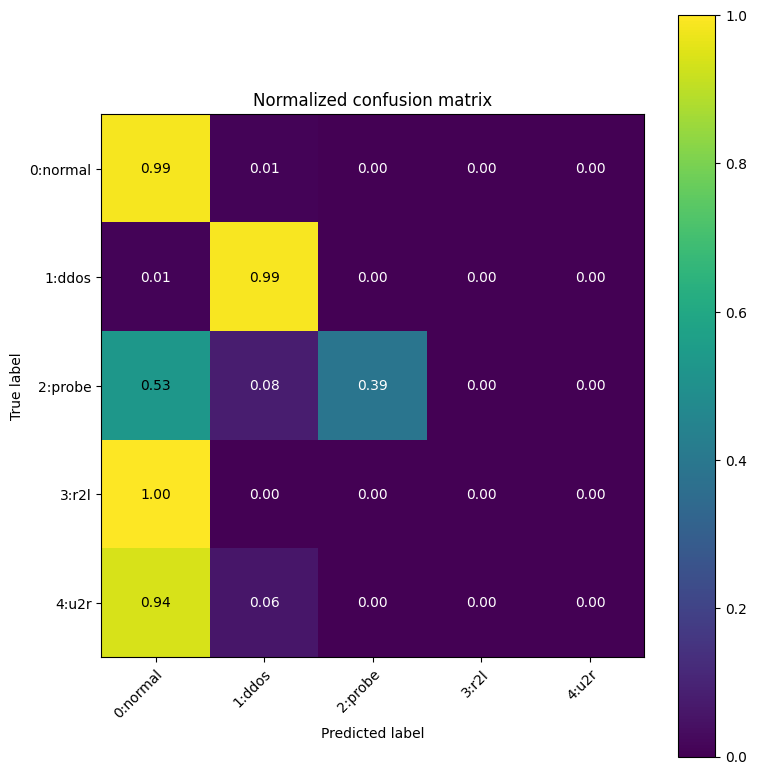

In [33]:
y_pred = model.predict(X_test)
class_names = np.array(['0:normal','1:ddos', '2:probe', '3:r2l', '4:u2r'])
plot_conf_mat(y_test, y_pred, class_names)

The confusion matrix was made with 'count' and 'srv_count' features and not SMOTE.

### Let's try SMOTE

In [34]:
print( "Samples per class before SMOTE: ", Counter(y_train) )
smote = SMOTE()
X_train_smoted, y_train_smoted = smote.fit_resample(X_train, y_train)
print( "Samples per class after SMOTE: ", Counter(y_train) )

Samples per class before SMOTE:  Counter({1: 274233, 0: 67868, 2: 2898, 3: 780, 4: 35})
Samples per class after SMOTE:  Counter({1: 274233, 0: 67868, 2: 2898, 3: 780, 4: 35})


Normalized confusion matrix
[[0.58585515 0.00710643 0.02706562 0.06820809 0.31176471]
 [0.01199403 0.97024525 0.01342717 0.00116869 0.00316485]
 [0.04052936 0.01571547 0.59801489 0.03473945 0.31100083]
 [0.01156069 0.         0.00578035 0.29190751 0.69075145]
 [0.         0.         0.05882353 0.05882353 0.88235294]]


<Axes: title={'center': 'Normalized confusion matrix'}, xlabel='Predicted label', ylabel='True label'>

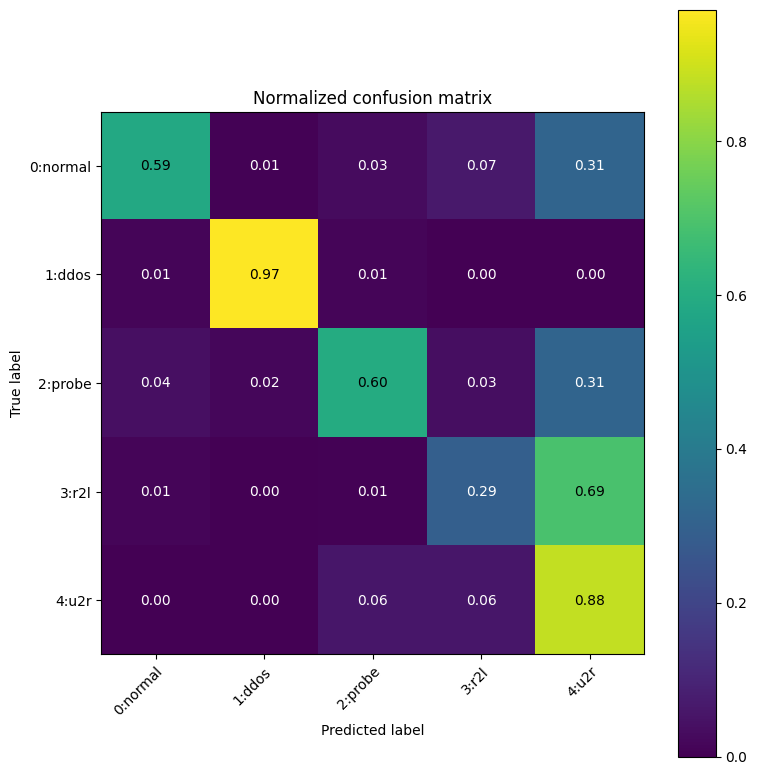

In [35]:
model.fit(X_train_smoted, y_train_smoted) # SMOTE
y_pred = model.predict(X_test)
class_names = np.array(['0:normal','1:ddos', '2:probe', '3:r2l', '4:u2r'])
plot_conf_mat(y_test, y_pred, class_names)

Conclusion:
 - SMOTE usefull
 - U2R = unauthorized access to local superuser (root) privileges, e.g., various ``buffer overflow'' attacks;
 - There is a kind of "column" effect in the confusion matrix and we want to improve U2R column so we need to add features that seems relevant to U2R
 - Add 'root_shell' feature to improve U2R column (1 if root shell is obtained; 0 otherwise )

## Try 'count', 'srv_count', 'root_shell' + SMOTE

Index(['root_shell', 'count', 'srv_count', 'attack'], dtype='object')
Index(['root_shell', 'count', 'srv_count'], dtype='object')
[0 4 1 3 2]
Normalized confusion matrix
[[0.54090445 0.00710643 0.01968718 0.3982999  0.03400204]
 [0.01357219 0.97024525 0.01312007 0.00181702 0.00124547]
 [0.06286187 0.02067825 0.54507858 0.36889992 0.00248139]
 [0.01156069 0.         0.00578035 0.97109827 0.01156069]
 [0.         0.         0.05882353 0.52941176 0.41176471]]


<Axes: title={'center': 'Normalized confusion matrix'}, xlabel='Predicted label', ylabel='True label'>

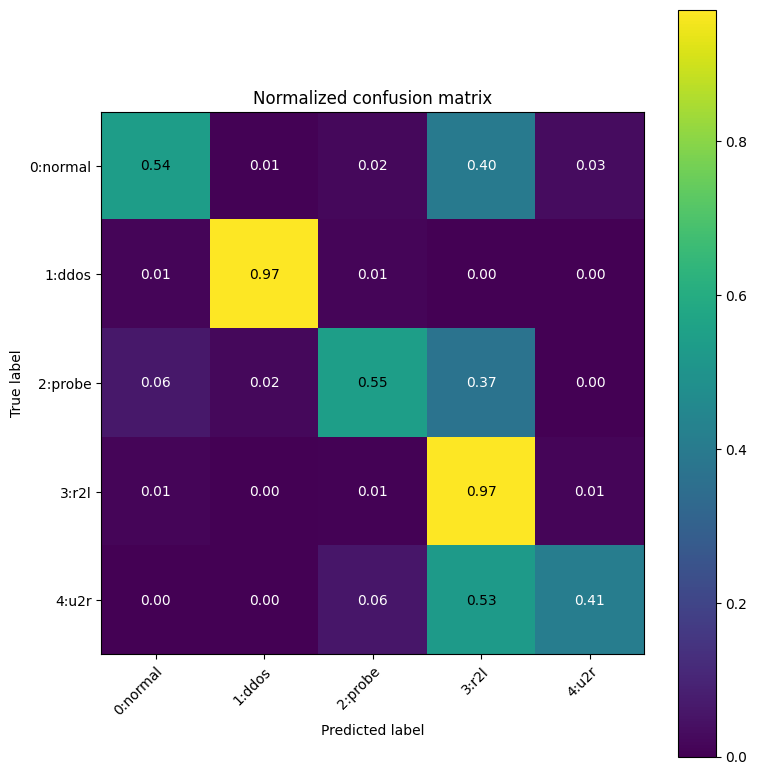

In [36]:
labels = df0.columns
labels_to_keep = ['count', 'srv_count', 'root_shell', 'attack']
labels_to_drop = [label for label in labels if label not in labels_to_keep]
df2 = df0.drop(labels=labels_to_drop, axis=1)
print(df2.columns)
X = df2.drop(labels='attack', axis=1)
y = df2['attack']
print(X.columns)
print(y.unique())
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.3, shuffle=True, random_state=4)
smote = SMOTE()
X_train_smoted, y_train_smoted = smote.fit_resample(X_train, y_train)
model = RandomForestClassifier(n_estimators=100, # 100 trees
                      criterion='gini', # Information gain
                      max_leaf_nodes=8, # Each tree cannot have more than that
                      random_state=5, # For reproducibility
                      n_jobs=-1, # Use all the CPUs
                      max_features = 'sqrt', # max_features=sqrt(n_features)
                      )

model.fit(X_train_smoted, y_train_smoted) # SMOTE
#model.fit(X_train, y_train) # No SMOTE
y_pred = model.predict(X_test)
class_names = np.array(['0:normal','1:ddos', '2:probe', '3:r2l', '4:u2r'])
plot_conf_mat(y_test, y_pred, class_names)

Conclusion:
- Samples are less predicted as U2R but there is the same "column" effect in the confusion matrix
- We need to add features that seems relevant to R2L now (R2L: unauthorized access from a remote machine, e.g. guessing password)
- We choose 'src_bytes' and 'dst_bytes' features to improve R2L column 
- src_bytes: number of data bytes from source to destination
- dst_bytes: number of data bytes from destination to source

## Try count', 'srv_count', 'root_shell','src_bytes', 'dst_bytes' + SMOTE

Index(['root_shell', 'count', 'srv_count', 'attack'], dtype='object')
Index(['src_bytes', 'dst_bytes', 'root_shell', 'count', 'srv_count'], dtype='object')
[0 4 1 3 2]
Normalized confusion matrix
[[7.24957497e-01 1.36008160e-04 5.72594356e-02 1.50527032e-01
  6.71200272e-02]
 [6.75623800e-03 9.70245255e-01 2.10620601e-02 5.11836212e-04
  1.42461079e-03]
 [1.65425972e-03 2.06782465e-02 9.69396195e-01 5.78990902e-03
  2.48138958e-03]
 [4.04624277e-02 0.00000000e+00 1.44508671e-02 9.07514451e-01
  3.75722543e-02]
 [2.35294118e-01 0.00000000e+00 0.00000000e+00 5.88235294e-02
  7.05882353e-01]]


<Axes: title={'center': 'Normalized confusion matrix'}, xlabel='Predicted label', ylabel='True label'>

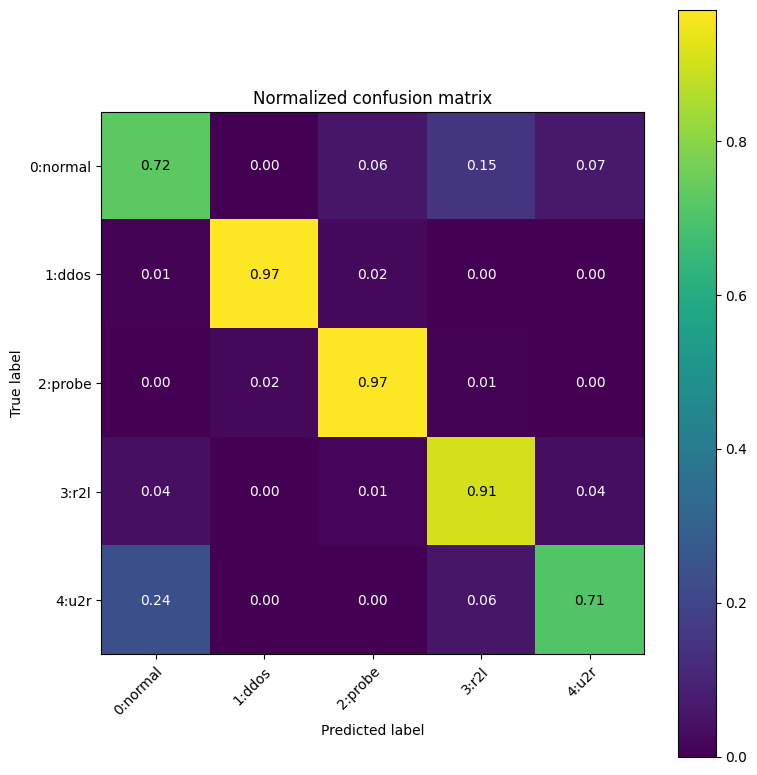

In [37]:
labels = df0.columns
labels_to_keep = ['count', 'srv_count', 'root_shell', 'src_bytes', 'dst_bytes', 'attack']
labels_to_drop = [label for label in labels if label not in labels_to_keep]
df3 = df0.drop(labels=labels_to_drop, axis=1)
print(df2.columns)
X = df3.drop(labels='attack', axis=1)
y = df3['attack']
print(X.columns)
print(y.unique())
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.3, shuffle=True, random_state=4)
smote = SMOTE()
X_train_smoted, y_train_smoted = smote.fit_resample(X_train, y_train)
model = RandomForestClassifier(n_estimators=100, # 100 trees
                      criterion='gini', # Information gain
                      max_leaf_nodes=8, # Each tree cannot have more than that
                      random_state=5, # For reproducibility
                      n_jobs=-1, # Use all the CPUs
                      max_features = 'sqrt', # max_features=sqrt(n_features)
                      )

model.fit(X_train_smoted, y_train_smoted) # SMOTE
#model.fit(X_train, y_train) # No SMOTE
y_pred = model.predict(X_test)
class_names = np.array(['0:normal','1:ddos', '2:probe', '3:r2l', '4:u2r'])
plot_conf_mat(y_test, y_pred, class_names)

Conclusion:
- Need to add a feature that caracterize U2R (U2R = unauthorized access to local superuser (root) privileges, e.g., various ``buffer overflow'' attacks)
- To make buffer overflow attacks, the attacker will need to send a lot of data to the server so we choose 'dst_host_srv_count' feature to improve U2R column
- dst_host_srv_count: number of connections to the same service as the current connection in the past two seconds

Index(['src_bytes', 'dst_bytes', 'root_shell', 'count', 'srv_count'], dtype='object')


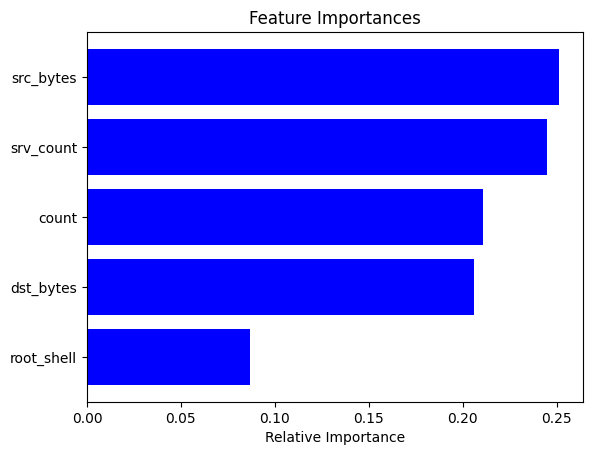

[(0.2514296235067695, 'src_bytes'),
 (0.24476084574396265, 'srv_count'),
 (0.21094346557091648, 'count'),
 (0.2060237388817425, 'dst_bytes'),
 (0.08684232629660897, 'root_shell')]

In [38]:
feature_names = X_test.columns
print(feature_names)
plot_feature_importances(model.feature_importances_, feature_names)
feature_names

# show the list of features sorted by importance
sorted(zip(model.feature_importances_, feature_names), reverse=True)

## Try 'count', 'srv_count', 'root_shell', 'dst_host_srv_count', 'src_bytes', 'dst_bytes' + SMOTE

Index(['src_bytes', 'dst_bytes', 'root_shell', 'count', 'srv_count',
       'dst_host_srv_count', 'attack'],
      dtype='object')
Index(['src_bytes', 'dst_bytes', 'root_shell', 'count', 'srv_count',
       'dst_host_srv_count'],
      dtype='object')
[0 4 1 3 2]


Normalized confusion matrix
[[7.48724923e-01 1.36008160e-04 5.73274396e-02 1.30057803e-01
  6.37538252e-02]
 [5.67285135e-03 9.72804436e-01 1.90147153e-02 1.79142674e-03
  7.16570697e-04]
 [8.27129859e-04 2.31596361e-02 9.66914806e-01 6.61703888e-03
  2.48138958e-03]
 [5.78034682e-03 0.00000000e+00 1.44508671e-02 9.36416185e-01
  4.33526012e-02]
 [0.00000000e+00 0.00000000e+00 5.88235294e-02 0.00000000e+00
  9.41176471e-01]]


<Axes: title={'center': 'Normalized confusion matrix'}, xlabel='Predicted label', ylabel='True label'>

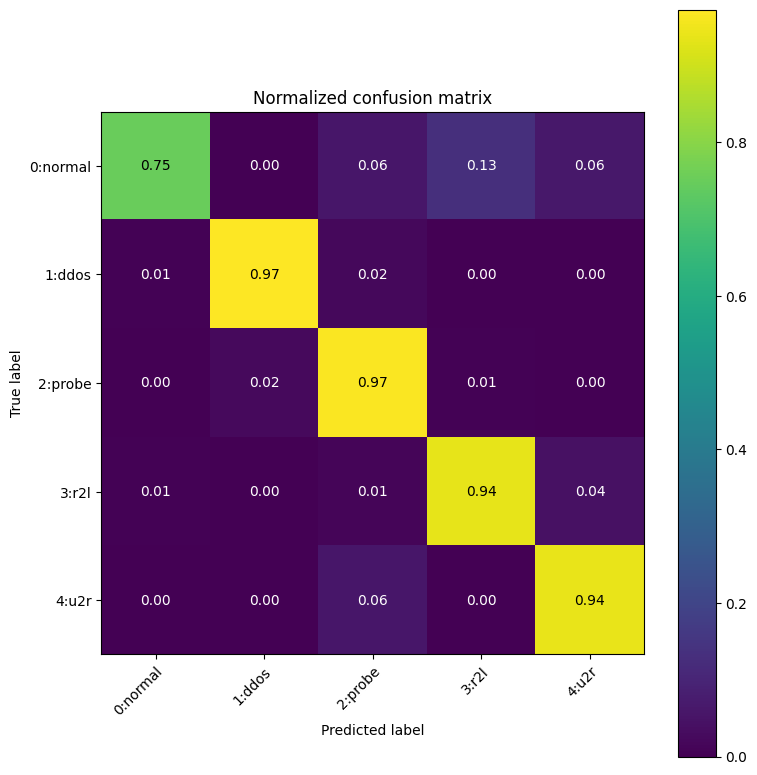

In [39]:
labels = df0.columns
labels_to_keep = ['count', 'srv_count', 'root_shell', 'dst_host_srv_count', 'src_bytes', 'dst_bytes', 'attack']
labels_to_drop = [label for label in labels if label not in labels_to_keep]
df4 = df0.drop(labels=labels_to_drop, axis=1)
print(df4.columns)
X = df4.drop(labels='attack', axis=1)
y = df4['attack']
print(X.columns)
print(y.unique())
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.3, shuffle=True, random_state=4)
smote = SMOTE()
X_train_smoted, y_train_smoted = smote.fit_resample(X_train, y_train)
model = RandomForestClassifier(n_estimators=100, # 100 trees
                      criterion='gini', # Information gain
                      max_leaf_nodes=8, # Each tree cannot have more than that
                      random_state=5, # For reproducibility
                      n_jobs=-1, # Use all the CPUs
                      max_features = 'sqrt', # max_features=sqrt(n_features)
                      )

model.fit(X_train_smoted, y_train_smoted) # SMOTE
#model.fit(X_train, y_train) # No SMOTE
y_pred = model.predict(X_test)
class_names = np.array(['0:normal','1:ddos', '2:probe', '3:r2l', '4:u2r'])
plot_conf_mat(y_test, y_pred, class_names)

Conclusion:
- seems to be pretty good now, we will try to improve this result with understanding of company usages
- Still confusion between normal and R2L (R2L: unauthorized access from a remote machine, e.g. guessing password)
- Nowadays companies use a lot of services in internet so we will add 'service_http'

## Try 'count', 'srv_count', 'root_shell', 'dst_host_srv_count', 'src_bytes', 'dst_bytes', 'service_http', + SMOTE

Index(['service_http', 'src_bytes', 'dst_bytes', 'root_shell', 'count',
       'srv_count', 'dst_host_srv_count', 'attack'],
      dtype='object')
Index(['service_http', 'src_bytes', 'dst_bytes', 'root_shell', 'count',
       'srv_count', 'dst_host_srv_count'],
      dtype='object')
[0 4 1 3 2]
Normalized confusion matrix
[[8.11118667e-01 3.40020401e-04 1.95171710e-02 1.07072424e-01
  6.19517171e-02]
 [6.57709533e-03 9.72232885e-01 2.06611218e-02 5.20366816e-04
  8.53060354e-06]
 [0.00000000e+00 2.06782465e-02 9.69396195e-01 6.61703888e-03
  3.30851944e-03]
 [5.78034682e-03 0.00000000e+00 1.44508671e-02 9.27745665e-01
  5.20231214e-02]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  1.00000000e+00]]


<Axes: title={'center': 'Normalized confusion matrix'}, xlabel='Predicted label', ylabel='True label'>

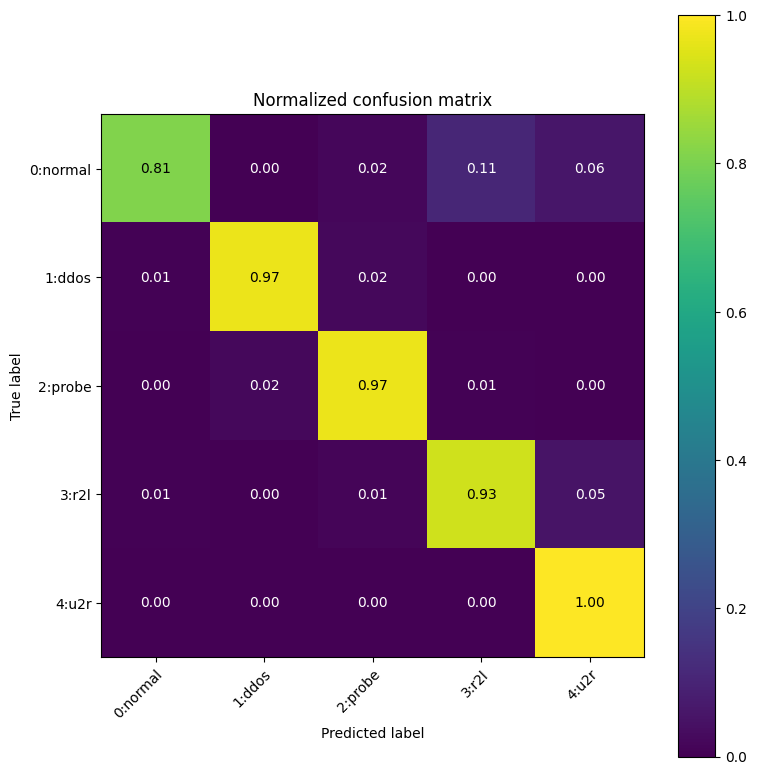

In [40]:
labels = df0.columns
labels_to_keep = ['count', 'srv_count', 'root_shell', 'dst_host_srv_count', 'src_bytes', 'dst_bytes', 'service_http', 'attack']
labels_to_drop = [label for label in labels if label not in labels_to_keep]
df5 = df0.drop(labels=labels_to_drop, axis=1)
print(df5.columns)
X = df5.drop(labels='attack', axis=1)
y = df5['attack']
print(X.columns)
print(y.unique())
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.3, shuffle=True, random_state=4)
smote = SMOTE()
X_train_smoted, y_train_smoted = smote.fit_resample(X_train, y_train)
model = RandomForestClassifier(n_estimators=100, # 100 trees
                      criterion='gini', # Information gain
                      max_leaf_nodes=8, # Each tree cannot have more than that
                      random_state=5, # For reproducibility
                      n_jobs=-1, # Use all the CPUs
                      max_features = 'sqrt', # max_features=sqrt(n_features)
                      )

model.fit(X_train_smoted, y_train_smoted) # SMOTE
#model.fit(X_train, y_train) # No SMOTE
y_pred = model.predict(X_test)
class_names = np.array(['0:normal','1:ddos', '2:probe', '3:r2l', '4:u2r'])
plot_conf_mat(y_test, y_pred, class_names)

Conclusion:
- confusion is better but not significant so we will try to improve this result with changing number of leaves

Index(['service_http', 'src_bytes', 'dst_bytes', 'root_shell', 'count',
       'srv_count', 'dst_host_srv_count'],
      dtype='object')


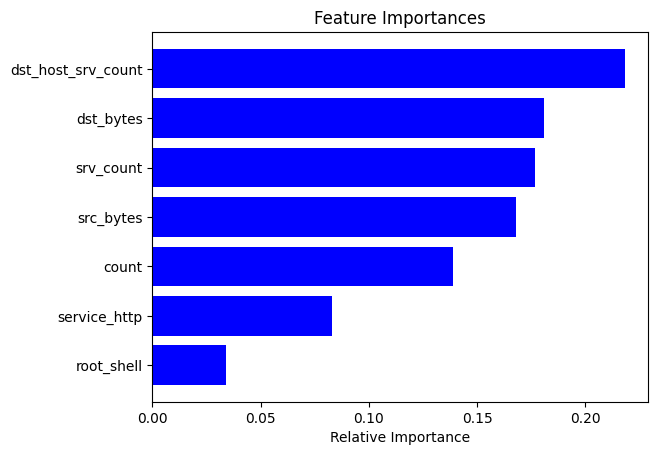

[(0.21823144562326335, 'dst_host_srv_count'),
 (0.18101236742482193, 'dst_bytes'),
 (0.17680809617449184, 'srv_count'),
 (0.1678563597340892, 'src_bytes'),
 (0.13910143694450916, 'count'),
 (0.08302094262897083, 'service_http'),
 (0.033969351469853706, 'root_shell')]

In [41]:
feature_names = X_test.columns
print(feature_names)
plot_feature_importances(model.feature_importances_, feature_names)
feature_names

# show the list of features sorted by importance
sorted(zip(model.feature_importances_, feature_names), reverse=True)

### Test with more leaves

Index(['service_http', 'src_bytes', 'dst_bytes', 'root_shell', 'count',
       'srv_count', 'dst_host_srv_count', 'attack'],
      dtype='object')
Index(['service_http', 'src_bytes', 'dst_bytes', 'root_shell', 'count',
       'srv_count', 'dst_host_srv_count'],
      dtype='object')
[0 4 1 3 2]
Normalized confusion matrix
[[9.60829650e-01 1.36008160e-04 1.12206732e-03 2.91737504e-02
  8.73852431e-03]
 [8.73533803e-03 9.77325656e-01 1.38110471e-02 1.19428450e-04
  8.53060354e-06]
 [2.48138958e-03 1.65425972e-02 9.73531844e-01 5.78990902e-03
  1.65425972e-03]
 [1.73410405e-02 0.00000000e+00 5.78034682e-03 9.45086705e-01
  3.17919075e-02]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  1.00000000e+00]]


<Axes: title={'center': 'Normalized confusion matrix'}, xlabel='Predicted label', ylabel='True label'>

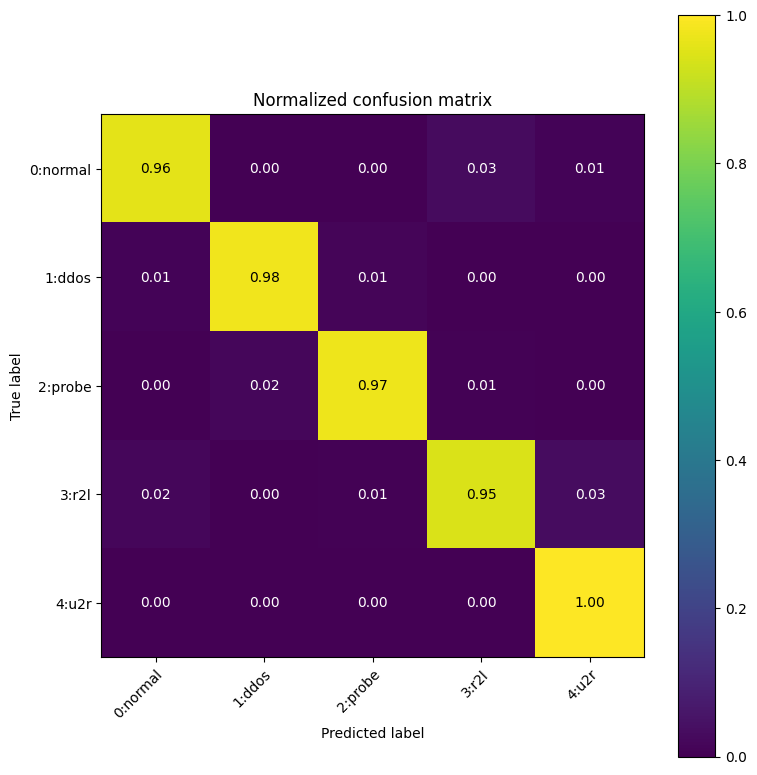

In [42]:
labels = df0.columns
labels_to_keep = ['count', 'srv_count', 'root_shell', 'dst_host_srv_count', 'src_bytes', 'dst_bytes', 'service_http', 'attack']
labels_to_drop = [label for label in labels if label not in labels_to_keep]
df6 = df0.drop(labels=labels_to_drop, axis=1)
print(df6.columns)
X = df6.drop(labels='attack', axis=1)
y = df6['attack']
print(X.columns)
print(y.unique())
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.3, shuffle=True, random_state=4)
smote = SMOTE()
X_train_smoted, y_train_smoted = smote.fit_resample(X_train, y_train)
model = RandomForestClassifier(n_estimators=100, # 100 trees
                      criterion='gini', # Information gain
                      max_leaf_nodes=32, # Each tree cannot have more than that
                      random_state=5, # For reproducibility
                      n_jobs=-1, # Use all the CPUs
                      max_features = 'sqrt', # max_features=sqrt(n_features)
                      )

model.fit(X_train_smoted, y_train_smoted) # SMOTE
#model.fit(X_train, y_train) # No SMOTE
y_pred = model.predict(X_test)
class_names = np.array(['0:normal','1:ddos', '2:probe', '3:r2l', '4:u2r'])
plot_conf_mat(y_test, y_pred, class_names)

With more trees doesn't improve the result

### Test with another random state because of 100% accuracy for U2R

Index(['service_http', 'src_bytes', 'dst_bytes', 'root_shell', 'count',
       'srv_count', 'dst_host_srv_count', 'attack'],
      dtype='object')
Index(['service_http', 'src_bytes', 'dst_bytes', 'root_shell', 'count',
       'srv_count', 'dst_host_srv_count'],
      dtype='object')
[0 4 1 3 2]


Normalized confusion matrix
[[9.62223733e-01 1.36008160e-04 1.36008160e-03 2.81196872e-02
  8.16048963e-03]
 [8.23203242e-03 9.75312433e-01 1.62507997e-02 2.04734485e-04
  0.00000000e+00]
 [5.78990902e-03 1.57154673e-02 9.74358974e-01 2.48138958e-03
  1.65425972e-03]
 [8.67052023e-03 0.00000000e+00 1.15606936e-02 9.45086705e-01
  3.46820809e-02]
 [5.88235294e-02 0.00000000e+00 0.00000000e+00 0.00000000e+00
  9.41176471e-01]]


<Axes: title={'center': 'Normalized confusion matrix'}, xlabel='Predicted label', ylabel='True label'>

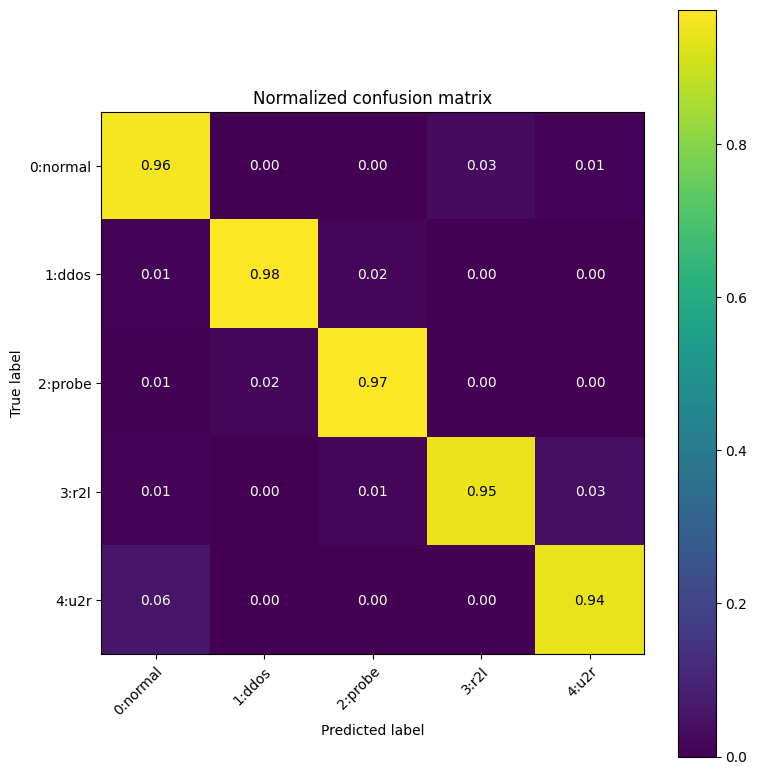

In [45]:
labels = df0.columns
labels_to_keep = ['count', 'srv_count', 'root_shell', 'dst_host_srv_count', 'src_bytes', 'dst_bytes', 'service_http', 'attack']
labels_to_drop = [label for label in labels if label not in labels_to_keep]
df7 = df0.drop(labels=labels_to_drop, axis=1)
print(df7.columns)
X = df7.drop(labels='attack', axis=1)
y = df7['attack']
print(X.columns)
print(y.unique())
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.3, shuffle=True, random_state=4)
smote = SMOTE()
X_train_smoted, y_train_smoted = smote.fit_resample(X_train, y_train)
model = RandomForestClassifier(n_estimators=100, # 100 trees
                      criterion='gini', # Information gain
                      max_leaf_nodes=32, # Each tree cannot have more than that
                      random_state=19, # For reproducibility
                      n_jobs=-1, # Use all the CPUs
                      max_features = 'sqrt', # max_features=sqrt(n_features)
                      )

model.fit(X_train_smoted, y_train_smoted) # SMOTE
#model.fit(X_train, y_train) # No SMOTE
y_pred = model.predict(X_test)
class_names = np.array(['0:normal','1:ddos', '2:probe', '3:r2l', '4:u2r'])
plot_conf_mat(y_test, y_pred, class_names)